<a href="https://colab.research.google.com/github/m-aliabbas/EvolutionaryComputing/blob/master/Resnet50LastLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import fastai
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
!ls chest_xray

ls: cannot access 'chest_xray': No such file or directory


In [0]:
!ls

chest_xray.zip	drive  sample_data


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
!ls chest_xray

test  train  val


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))

In [0]:
print(len(filesPos),len(filesNeg))

1341 3875


In [0]:
from fastai import *
import shutil
def copyfiles(filesName,dest):
  c=0
  for file in filesName:
    shutil.copy(file, dest)
    c+=1
  print("Copied "+str(c))

In [0]:
!mkdir dataset1

In [0]:
!mkdir dataset1/train

In [0]:
!ls dataset1

train


In [0]:
!mkdir dataset1/train/PNEUMONIA
!mkdir dataset1/train/NORMAL

In [0]:
!ls dataset1/train/

NORMAL	PNEUMONIA


In [0]:
filesNeg=filesNeg[:1340]

In [0]:
import random 
random.seed(3000)
random.shuffle(filesNeg)
random.shuffle(filesPos)

In [0]:
!ls chest_xray

test  train  val


In [0]:
copyfiles(filesPos,'dataset1/train/NORMAL')

Copied 1341


In [0]:
copyfiles(filesNeg,'dataset1/train/PNEUMONIA')

Copied 1340


In [0]:
!mkdir dataset1/valid

In [0]:
!mkdir dataset1/test

In [0]:
!cp -r chest_xray/val dataset1/

In [0]:
!cp -r chest_xray/test dataset1/

In [0]:
!rm -rf dataset1/valid

In [0]:
!mv dataset1/val dataset1/valid

In [0]:
np.random.seed(1234)
path='dataset1'
data = ImageDataBunch.from_folder(path,
        ds_tfms=get_transforms(do_flip=True,max_lighting=0.1),
        seed=1234,
        valid_pct=0.2,                          
        size=224,
        num_workers=8,
        bs=32,
        test="test")


In [0]:
data

ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,PNEUMONIA,NORMAL,PNEUMONIA
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1

In [0]:
data.classes

['NORMAL', 'PNEUMONIA']

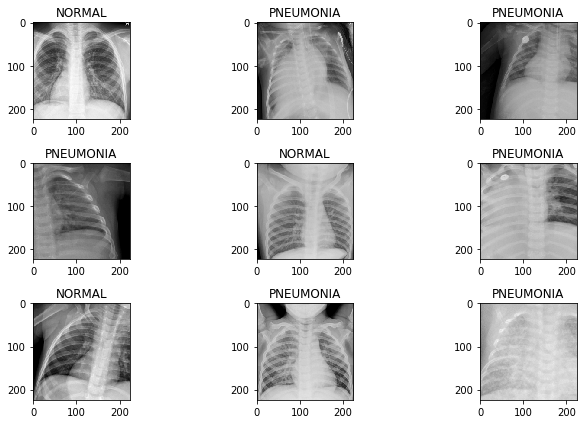

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score
# from sklearn.metrics import f1_score
# def f1_out(y_ture,y_pred,tens=True):
#     f1a_score=f1_score(y_true, torch.sigmoid(y_pred)[:,1], average='macro') 
#     if tens:
#         f1a_score=tensor(f1a_score)
#     else:
#         f1a_score=f1a_score
#     return f1a_score

In [0]:

import torch 
import torchvision
resnet50PT = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 35787744.45it/s]


In [0]:
num_ftrs = resnet50PT.fc.in_features
resnet50PT.fc=nn.Sequential(
    
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.3),
    nn.Linear(128, 2),
)

In [0]:
resnet50PT=resnet50PT.cuda()

In [0]:

auc=[]
loss=[]
aucc=[]
learn = Learner(data, resnet50PT, metrics=[error_rate, accuracy,f1_score_a])

In [0]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,PNEUMONIA,NORMAL,PNEUMONIA
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1

In [0]:
learn.freeze_to(100)

In [0]:
learn.recorder.plot()

AttributeError: ignored

In [0]:
from fastai.callbacks import *
learn.fit_one_cycle(10,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.595319,0.405908,0.103916,0.896084,0.897423,02:50
1,0.308442,0.183225,0.060241,0.939759,0.941716,02:48
2,0.205356,0.138012,0.048193,0.951807,0.952119,02:46
3,0.150641,0.129169,0.045181,0.954819,0.949178,02:46
4,0.125202,0.100323,0.033133,0.966867,0.963120,02:46
5,0.107604,0.097841,0.034639,0.965361,0.966197,02:45
6,0.094339,0.088385,0.039157,0.960843,0.958466,02:45
7,0.084427,0.089047,0.028614,0.971386,0.970778,02:45
8,0.075619,0.076340,0.028614,0.971386,0.970671,02:46
9,0.072832,0.068789,0.024096,0.975904,0.975304,02:48


Better model found at epoch 0 with f1_score_a value: 0.8974229693412781.
Better model found at epoch 1 with f1_score_a value: 0.9417159557342529.
Better model found at epoch 2 with f1_score_a value: 0.9521190524101257.
Better model found at epoch 4 with f1_score_a value: 0.9631202220916748.
Better model found at epoch 5 with f1_score_a value: 0.9661970734596252.
Better model found at epoch 7 with f1_score_a value: 0.9707778692245483.
Better model found at epoch 9 with f1_score_a value: 0.9753036499023438.


In [0]:
lossArray=[]

lossArray.append(learn.recorder.losses)

In [0]:
auc=[]
auc.append(learn.recorder.metrics)


In [46]:
auc

[[[tensor(0.1039), tensor(0.8961), tensor(0.8974)],
  [tensor(0.0602), tensor(0.9398), tensor(0.9417)],
  [tensor(0.0482), tensor(0.9518), tensor(0.9521)],
  [tensor(0.0452), tensor(0.9548), tensor(0.9492)],
  [tensor(0.0331), tensor(0.9669), tensor(0.9631)],
  [tensor(0.0346), tensor(0.9654), tensor(0.9662)],
  [tensor(0.0392), tensor(0.9608), tensor(0.9585)],
  [tensor(0.0286), tensor(0.9714), tensor(0.9708)],
  [tensor(0.0286), tensor(0.9714), tensor(0.9707)],
  [tensor(0.0241), tensor(0.9759), tensor(0.9753)]]]

In [47]:
learn.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,PNEUMONIA,NORMAL,PNEUMONIA
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1

In [0]:
learn.fit_one_cycle(10,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='auc_score')])
learn.recorder.plot_losses()
learn.recorder.plot(show_momentum=True)
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.summary()

ResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
_______________________________________________________

In [0]:
learn.load('bestmodel')

In [49]:
learn.unfreeze()
learn.fit_one_cycle(5,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.273476,2.658261,0.355422,0.644578,0.854424,02:46
1,0.307223,0.305591,0.094880,0.905120,0.900142,02:48
2,0.301833,5.199765,0.474398,0.525602,0.405343,02:48
3,0.266630,0.465460,0.108434,0.891566,0.892655,02:48
4,0.228846,0.197502,0.073795,0.926205,0.923505,02:48


Better model found at epoch 0 with f1_score_a value: 0.8544236421585083.
Better model found at epoch 1 with f1_score_a value: 0.9001420736312866.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Better model found at epoch 4 with f1_score_a value: 0.9235054850578308.


In [0]:
learn.recorder.plot_losses()
learn.recorder.plot()

In [0]:
learn.lr_find()
learn.recorder.plot()

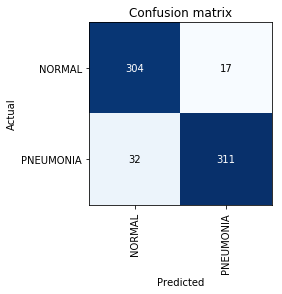

In [51]:

learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn.load('Res')

In [0]:
# learn.lr_find()
# # learn.recorder.plot()

In [0]:
# learn.fit_one_cycle(20,max_lr=(1e-07),wd=0.25)

In [0]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [0]:
# learn.lr_find()

In [0]:
# learn.recorder.plot()

In [52]:
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

Precision of Model = 0.9067055393586005 Recall of Model  0.948170731707317
F1 Score of Model = 0.9269746646795827
